In [28]:
import pandas as pd
import numpy as np
import torch
from transformers import LongformerTokenizer, LongformerModel
from sklearn.decomposition import PCA

In [21]:
!pip install scikit-learn matplotlib

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [2]:
lyrics = [
    """I never miss a beat
       I'm lightnin' on my feet
       And that's what they don't see, mm-mm
       That's what they don't see, mm-mm
       I'm dancin' on my own (Dancin' on my own)
       I make the moves up as I go (Moves up as I go)
       And that's what they don't know, mm-mm
       That's what they don't know, mm-mm
      """
]

In [3]:

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerModel.from_pretrained("allenai/longformer-base-4096")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
def get_embedding(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=4096)
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state[0, 0, :]
        return torch.nn.functional.normalize(emb, p=2, dim=0).numpy()
    except:
        return np.nan

In [5]:
def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=4096)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return torch.nn.functional.normalize(embeddings, p=2, dim=1).numpy()

In [6]:
emb = get_embeddings(lyrics)

In [7]:
emb.shape

(1, 768)

In [6]:
df = pd.read_csv('/content/playlist_with_lyrics_clean.csv')

In [7]:
df.head()

,id,name,popularity,artist,lyrics
0,0WbMK4wrZ1wFSty9F7FCgu,"Good Luck, Babe!",92,Chappell Roan,"[Verse 1]\nIt's fine, it's cool\nYou can say t..."
1,3HMY0r2BAdpasXMY8rseR0,Too Sweet,78,Hozier,[Verse 1]\nIt can't be said I'm an early bird\...
2,3tLVfEh8kJhMkDaxvOzK1M,Insecure,47,Tom Misch,"[Verse 1]\nI heard this guy, says he wants you..."
3,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,96,Billie Eilish,[Intro]\n(But I wanna stay)\n\n[Verse 1]\nI wa...
4,5eVG50IlyjSevPsWnSI76r,The Thrill Is Gone.,58,RAYE,"[Verse 1]\nCard games and heart games\nI said,..."


In [14]:
# df['embedding'] = df['lyrics'].apply(lambda x: get_embedding(x))

In [ ]:
# df['embedding'] = get_embeddings(df['lyrics'].tolist())


In [9]:
batch_size = 8
embeddings = []

for i in range(0, len(df), batch_size):
    print(f"Processing {i} to {i + batch_size}")
    batch = df['lyrics'].tolist()[i:i + batch_size]
    embeddings.extend(get_embeddings(batch))



Processing 0 to 8
Processing 8 to 16
Processing 16 to 24
Processing 24 to 32
Processing 32 to 40
Processing 40 to 48
Processing 48 to 56
Processing 56 to 64
Processing 64 to 72
Processing 72 to 80
Processing 80 to 88


In [14]:
type(embeddings[0])

numpy.ndarray

In [15]:
df['embedding'] = embeddings


In [17]:
df.tail()

,id,name,popularity,artist,lyrics,embedding
78,1oOD1pV43cV9sHg97aBdLs,Dean Town,51,Vulfpeck,(Yo)(Yo),"[-0.0022316205, 0.0055069495, -0.00081262377, ..."
79,73W5aXorr5vxrySFcoZqIN,Renegade,65,Big Red Machine,[Verse 1: Taylor Swift]\nI tapped on your wind...,"[-0.006705934, 0.005236348, 6.045941e-05, -0.0..."
80,1iGOI54dl6Ps1kYlSpPZzg,Overseas,55,Thundercat,"[Verse: Thundercat]\nGirl, you're so fly (So f...","[-0.0034335176, 0.0045366585, -0.00022503448, ..."
81,0Lf2PlT8IPAaWc59a2fWU6,For James,69,Pale Jay,[Unique Verse]\nI took everything when you wer...,"[-0.0062241415, 0.0049878745, -0.0007260269, -..."
82,7nnWIPM5hwE3DaUBkvOIpy,Drive,78,Incubus,[Verse 1]\nSometimes I feel the fear of\nUncer...,"[-0.0064137597, 0.0035669676, -0.0032583359, -..."


In [18]:
df.to_csv('./embeddinged.csv')

In [57]:
embeddings = np.array(df['embedding'].tolist())

In [60]:
cluster_labels = df['cluster'].values

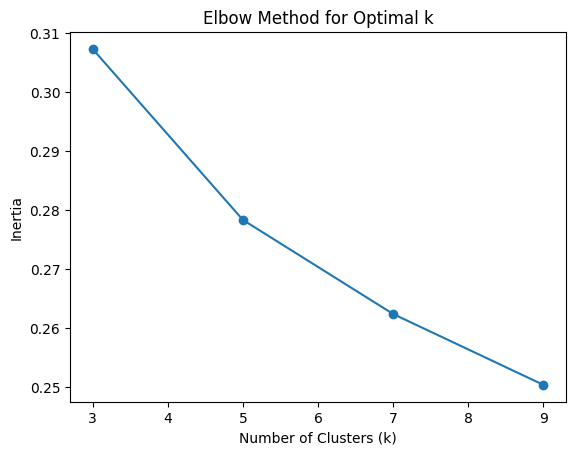

In [58]:
inertia = []
for i in range(3, 11, 2):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.plot(range(3, 11, 2), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()



In [61]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

df['cluster'] = cluster_labels

print(df[['name', 'cluster']])

                   name  cluster
0      Good Luck, Babe!        2
1             Too Sweet        4
2              Insecure        3
3    BIRDS OF A FEATHER        1
4   The Thrill Is Gone.        4
..                  ...      ...
78            Dean Town        0
79             Renegade        1
80             Overseas        2
81            For James        4
82                Drive        1

[83 rows x 2 columns]


In [62]:
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(embeddings)

In [63]:
explained_variance_ratio_2d = pca_2d.explained_variance_ratio_

In [64]:
print(explained_variance_ratio_2d)

[0.11618381 0.08768714]


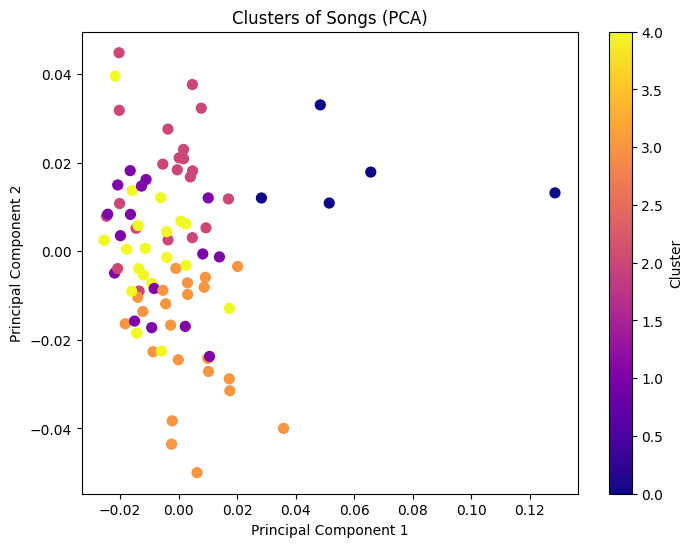

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='plasma', s=50)
plt.title('Clusters of Songs (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [69]:
pca_3d = PCA(n_components=3)
embeddings_3d = pca_3d.fit_transform(embeddings)

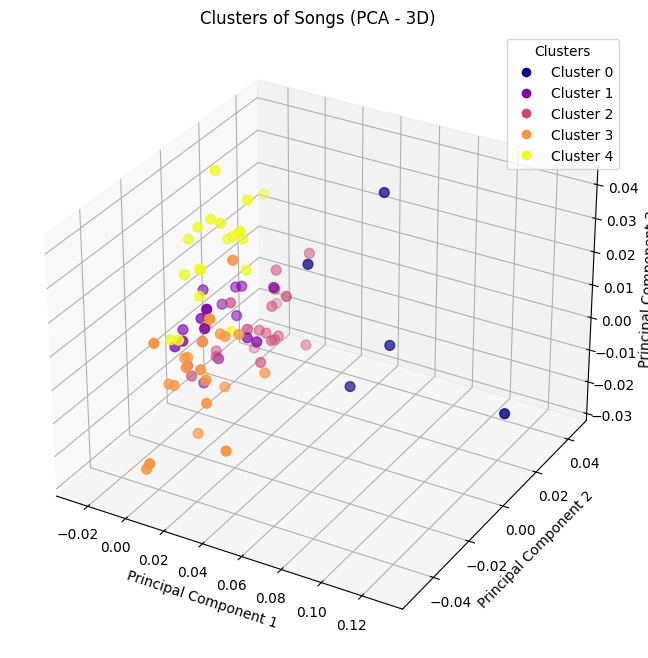

In [70]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
                    c=cluster_labels, cmap='plasma', s=50)

handles, labels = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in range(len(np.unique(cluster_labels)))]

ax.legend(handles, legend_labels, title="Clusters")

ax.set_title('Clusters of Songs (PCA - 3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

In [71]:
print(pca_3d.explained_variance_ratio_)

[0.11618382 0.08768709 0.05883202]


In [72]:
df[df['cluster'] == 0]

,id,name,popularity,artist,lyrics,embedding,cluster
27,1gPeJMO7Az6ZtzHiaKUTWb,Opendoors,71,Jitwam,[Verse]\nI will open doors 'cause I believe in...,"[-0.0040361746, 0.002202327, 0.003108137, -0.0...",0
31,4rCKRVJZKVysScn2piDuOT,Something For Your M.I.N.D.,57,Superorganism,[Verse 1]\nI know you think I'm a psychopath\n...,"[-0.0059184204, 0.005905143, 0.0020504952, -0....",0
53,6xHMi6HSt7yJvm3n81JZn6,Magic Hour,66,¿Téo?,[Instrumental]\n\n[Outro]\n(Yeah)\n(Uh-huh)\n(...,"[-0.00498348, -0.0011624602, 0.008663301, 0.00...",0
76,0WFryfbNKPXVtVQlz5dZ8H,hotline (edit),75,Billie Eilish,[Instrumental]\n\n[Verse]\n(Late night when yo...,"[-0.0055283466, 0.0056686047, 0.003992309, -0....",0
78,1oOD1pV43cV9sHg97aBdLs,Dean Town,51,Vulfpeck,(Yo)(Yo),"[-0.0022316205, 0.0055069495, -0.00081262377, ...",0


In [73]:
df[df['cluster'] == 1]

,id,name,popularity,artist,lyrics,embedding,cluster
3,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,96,Billie Eilish,[Intro]\n(But I wanna stay)\n\n[Verse 1]\nI wa...,"[-0.007920345, 0.005413141, -0.00044097356, -0...",1
16,1L94M3KIu7QluZe63g64rv,Alive,73,Pearl Jam,"[Verse 1]\n""Son,"" she said, ""have I got a litt...","[-0.011390713, 0.006696341, 0.00091045874, -0....",1
26,3qhlB30KknSejmIvZZLjOD,End of Beginning,88,Djo,"[Verse 1]\nJust one more tear to cry, one tear...","[-0.008457175, 0.0081793945, 0.00062051095, -0...",1
33,70eyG7pqKozUvKPKXLXmpI,i am not who i was,78,Chance Peña,[Verse 1]\nI've been living on the road\nMade ...,"[-0.0062716026, 0.006102651, -0.00081337715, -...",1
37,7mMlbJlXXo2mRtQ4R9sIzD,Hide and Seek,53,Imogen Heap,[Verse 1]\nWhere are we?\nWhat the hell is goi...,"[-0.004438764, 0.0024409639, 0.00020152632, -0...",1
39,3Fwebmu4BzPUpDtPZo0qHb,16 CARRIAGES,57,Beyoncé,[Chorus]\nSixteen carriages drivin' away\nWhil...,"[-0.0042353314, 0.0042357035, -0.0006113077, -...",1
40,1hn1kCOG5dm1XgZYKpfaLR,Breaking Up Slowly,54,Lana Del Rey,[Chorus: Nikki Lane]\nBreakin' up slowly is a ...,"[-0.0054150242, 0.00570681, 0.0004089192, -0.0...",1
43,3JqEamRw9aUvTKIhPXne9J,Spinnin,54,Madison Beer,"[Intro]\n(Ah, ah)\n(Ah, ah)\n\n[Verse 1]\nDid ...","[-0.005699755, 0.00497116, -0.00032500268, -0....",1
49,7CH99b2i1TXS5P8UUyWtnM,Them Changes,68,Thundercat,"[Verse 1]\nNobody move, there's blood on the f...","[-0.0059205107, 0.0026090587, 2.6256865e-05, -...",1
52,3wPm5GutqeJtOgsjwbtvnh,as good a reason,51,Paris Paloma,"[Intro]\n(Ey-ey-ey-ey, ey-ey-ey-ey)\n(La-la-la...","[-0.0040054293, 0.0033781268, 0.001401307, -0....",1


In [74]:
df[df['cluster'] == 2]

,id,name,popularity,artist,lyrics,embedding,cluster
0,0WbMK4wrZ1wFSty9F7FCgu,"Good Luck, Babe!",92,Chappell Roan,"[Verse 1]\nIt's fine, it's cool\nYou can say t...","[-0.0065792506, 0.007371035, 0.002484667, -0.0...",2
5,6dfwRetlyLPBoQzdufbOWj,Bite Me,59,Avril Lavigne,"[Intro]\nEh-oh\nYou shoulda known better, bett...","[-0.0061669964, 0.004107565, -0.00019552949, -...",2
9,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,88,Taylor Swift,"[Intro]\n(Yeah, yeah, yeah, yeah)\n\n[Verse 1]...","[-0.0033090322, 0.005124203, 0.0017204197, -0....",2
10,7wLShogStyDeZvL0a6daN5,TEXAS HOLD 'EM,73,Beyoncé,[Chorus]\nThis ain't Texas (Woo)\nAin't no hol...,"[-0.003538436, 0.0020410053, -0.00074071146, -...",2
13,5N3hjp1WNayUPZrA8kJmJP,Please Please Please,84,Sabrina Carpenter,"[Verse 1]\nI know I have good judgment, I know...","[-0.0056654583, 0.005158006, 0.00093492866, -0...",2
17,5JiU3gLHz9AvUnrhXgOmos,Risk,79,Gracie Abrams,[Verse 1]\nLook at me now\nSaid I wouldn't do ...,"[-0.00680942, 0.001813103, 0.00087271957, -0.0...",2
18,71p2ub5QJhJTzfvXbXaUXd,High No More,72,Hajaj,"[Verse 1]\nMy love, we used to move you\nMy lo...","[-0.00741103, 0.008420995, 0.0010107293, -0.00...",2
20,2qSkIjg1o9h3YT9RAgYN75,Espresso,88,Sabrina Carpenter,[Chorus]\nNow he's thinkin' 'bout me every nig...,"[-0.007892849, 0.004397791, -0.00016883986, -0...",2
24,7FOgcfdz9Nx5V9lCNXdBYv,Red Wine Supernova,82,Chappell Roan,"[Verse 1]\nShe was a playboy, Brigitte Bardot\...","[-0.0016427435, 0.0024693925, 0.0009913277, -0...",2
28,4A8pBxx0of2Y8r56dT0atf,Hallucinogenics (feat. Lana Del Rey),56,Matt Maeson,[Chorus: Matt Maeson & Lana Del Rey]\nPushing ...,"[-0.008325187, 0.001431572, -8.78422e-05, -0.0...",2


In [75]:
df[df['cluster'] == 3]

,id,name,popularity,artist,lyrics,embedding,cluster
2,3tLVfEh8kJhMkDaxvOzK1M,Insecure,47,Tom Misch,"[Verse 1]\nI heard this guy, says he wants you...","[-0.0064497674, 0.0055897096, 0.0024123862, -0...",3
6,0FTpFi1BlqoBVELlh7jK50,Le Départ,68,Adi Oasis,[Verse]\nWatching the clouds out the window\nO...,"[-0.0050036795, 0.00873454, 0.00041712055, -0....",3
8,5qJqzpNdEbt92roedFwoDR,Left Hand Free,70,alt-J,"[Verse 1]\nAin't shady, baby, I'm hot\nLike th...","[-0.003745228, 0.0050608316, -0.0017488681, -0...",3
12,1DrlLvlYd1FIjNavRm6NdX,Back Pocket,61,Vulfpeck,[Refrain]\nI know\nThat it's taken me all this...,"[-0.0046992856, 0.0074564223, 0.00030981083, -...",3
14,3U5JVgI2x4rDyHGObzJfNf,Unwritten,84,Natasha Bedingfield,[Verse 1]\nI am unwritten\nCan't read my mind\...,"[-0.005153762, 0.005398222, 0.00089120964, -0....",3
15,5zT5cMnMKoyruPj13TQXGx,I Found,73,Amber Run,[Verse 1]\nAnd I'll use you as a warning sign\...,"[-0.007287976, 0.0048278277, -0.0008806209, -0...",3
19,39rHfrVqCX6A55GF7uOZSC,1612,53,Vulfpeck,"[Intro]\nOoh, it's a tzimmes\nBut you need to ...","[-0.0045961053, 0.0055230823, 0.0010796611, -0...",3
21,2LXtyj95dK56ENS1QLt4IB,Beach Baby,71,Bon Iver,"[Verse]\nWhen you're out, tell your lucky one\...","[-0.0037703821, 0.006992773, 0.00033119123, -0...",3
23,48wH8bAxvBJO2l14GmNLz7,Wait for the Moment,58,Vulfpeck,"Mom said, ""Wait for the moment!""\nGone home, w...","[-0.008570714, 0.0034266189, 0.0005053126, -0....",3
25,0RnxpSzxzwZgFQ0NahQr9K,Easily,66,Bruno Major,[Chorus]\nDon't you tell me that it wasn't mea...,"[-0.0073521025, 0.007897046, 0.001615776, -0.0...",3


In [76]:
df[df['cluster'] == 4]

,id,name,popularity,artist,lyrics,embedding,cluster
1,3HMY0r2BAdpasXMY8rseR0,Too Sweet,78,Hozier,[Verse 1]\nIt can't be said I'm an early bird\...,"[-0.005888942, 0.0038774689, 0.0011845112, -0....",4
4,5eVG50IlyjSevPsWnSI76r,The Thrill Is Gone.,58,RAYE,"[Verse 1]\nCard games and heart games\nI said,...","[-0.005201367, 0.005125996, -0.00045920152, -0...",4
7,1dIjkfmkUdcl9LOQG3nbdn,Rewired,6,Gabbie Hanna,[Verse 1]\nI walk the boulevard of broken hear...,"[-0.007108248, 0.005416822, 0.00064803753, -0....",4
11,629DixmZGHc7ILtEntuiWE,LUNCH,84,Billie Eilish,"[Intro]\nOh, mm-mm\n\n[Chorus]\nI could eat th...","[-0.007169119, 0.0021977343, -0.0029379863, -0...",4
22,6J2LdBN97cDWn0MLxYh9HB,July,80,Noah Cyrus,[Verse 1]\nI've been holding my breath\nI've ...,"[-0.0054914174, 0.0048250086, -0.0008553933, -...",4
30,7AkPusgKsrTqbOcTTbRnFr,Halloween,58,Novo Amor,[Verse 1]\nAll the good words have left my mou...,"[-0.0030360215, 0.0034544843, -0.00065588864, ...",4
41,26MJjeJ0NSOQDKeZzrEFMl,hate to be lame,64,Lizzy McAlpine,[Verse 1: Lizzy McAlpine]\nIt's always on the ...,"[-0.0032769332, 0.0015249033, 0.00031477658, -...",4
42,4q5YezDOIPcoLr8R81x9qy,I Can Do It With a Broken Heart,81,Taylor Swift,"[Verse 1]\nI can read your mind\n""She's having...","[-0.0042069727, 0.0059514907, 0.00071885996, -...",4
44,1jSAARNT7fzLTcPc4IUQQz,If I Got It (Your Love Brought It),70,Aaron Frazer,[Chorus]\nIf I got a penny or a dime\nOr any p...,"[-0.0067064697, 0.004581723, 0.00019599167, -0...",4
48,7Iiek3SL6PluRxj9IgbTC1,Cure For Me,62,AURORA,"[Verse 1]\nI run from the liars, the fuel on t...","[-0.006905077, 0.0063681845, -0.00055281253, -...",4
